In [1]:
import sys
from pathlib import Path

import pandas as pd

# Add the notebooks directory to the path
sys.path.append(str(Path.cwd().parent))

from charts import (
    latency_box_plot,
    latency_distribution_plot,
    latency_line_plot,
)
from functions import calculate_latencies
from utils import fix_timestamps_timezone

experiment_name = "experiment08"

df_cloud = pd.read_parquet(f"../../data/raw/{experiment_name}/2025-12-26-16_05_10-avro-cloud.parquet")
df_cloud = df_cloud.sort_values("source_timestamp")
df_edge = pd.read_parquet(f"../../data/raw/{experiment_name}/2025-12-26-16_14_09-avro-edge.parquet")
df_edge = df_edge.sort_values("source_timestamp")

In [2]:
df_edge = fix_timestamps_timezone(df_edge)
df_cloud = fix_timestamps_timezone(df_cloud)

In [3]:
df_cloud = calculate_latencies(df_cloud)
df_edge = calculate_latencies(df_edge)

In [4]:
df_cloud_filtered = df_cloud[
    (df_cloud["source_timestamp"] >= "2025-12-26 14:15:00+00:00") &
    (df_cloud["source_timestamp"] <= "2025-12-26 16:25:00+00:00")
]

df_edge_filtered = df_edge[
    (df_edge["source_timestamp"] >= "2025-12-26 14:15:00+00:00") &
    (df_edge["source_timestamp"] <= "2025-12-26 16:25:00+00:00")
]

/home/ark/streaming-pipeline/notebooks/charts.py:1491: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  long_df.groupby(["stage", "environment"])["latency_s"]


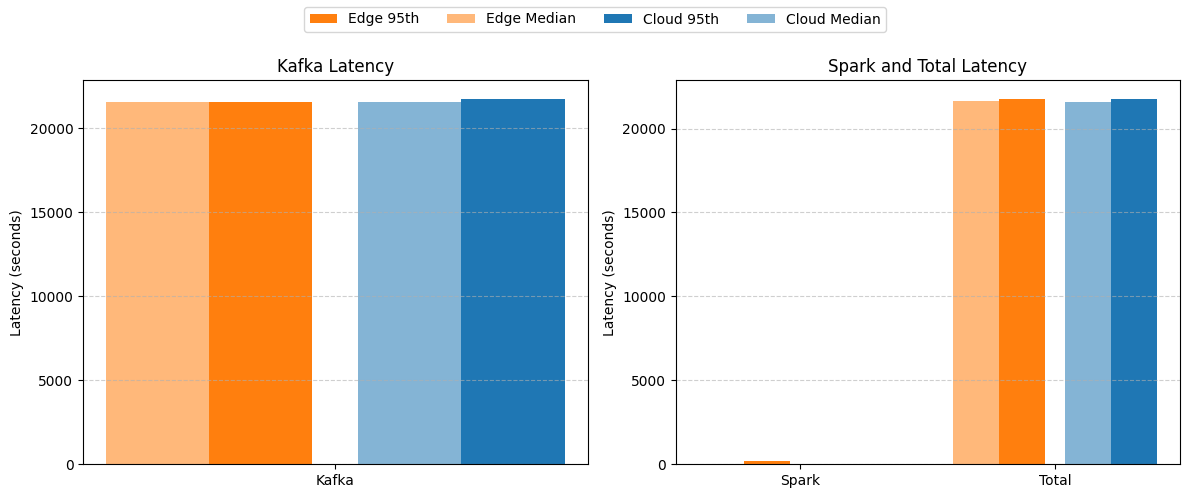

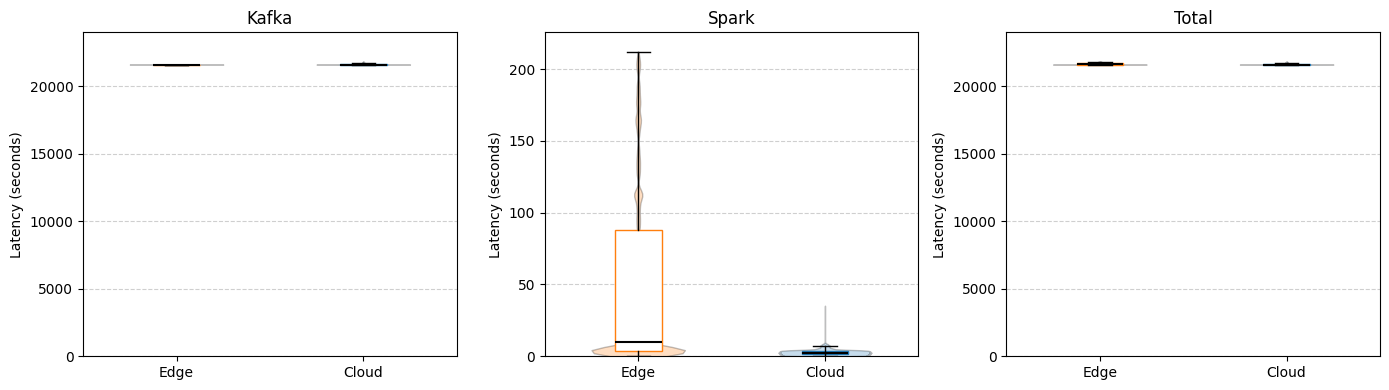

In [37]:
from charts import latency_summary_bar_chart, latency_violin_box_overlay

# Ensure a common schema like: ['environment', 'stage', 'latency_s']
df_edge_filtered["environment"] = "Edge"
df_cloud_filtered["environment"] = "Cloud"
df = pd.concat([df_edge_filtered, df_cloud_filtered], ignore_index=True)

# Now plot
latency_summary_bar_chart(df, save_path="./latency_summary.png")
latency_violin_box_overlay(df, save_path="./latency_violin.png")

In [38]:
import numpy as np
from charts import _prepare_latency_long


def summarize_latencies_ms(df: pd.DataFrame) -> pd.DataFrame:
    long_df = _prepare_latency_long(df)
    summ = (
        long_df.groupby(["stage", "environment"])["latency_s"]
        .agg(
            median=lambda s: np.nanmedian(s),
            iqr=lambda s: np.nanpercentile(s, 75) - np.nanpercentile(s, 25),
            p95=lambda s: np.nanpercentile(s, 95),
        )
        .mul(1000)  # seconds -> milliseconds
        .round(1)   # 0.1 ms resolution is sufficient for reporting
        .reset_index()
        .pivot(index=["stage"], columns="environment")
        .sort_index()
    )
    # Make a flat column index like 'median.Edge (ms)'
    summ.columns = [f"{stat}.{env} (ms)" for stat, env in summ.columns]
    return summ

stats_ms = summarize_latencies_ms(df)
display(stats_ms)

# Convenience accessors for your paragraph (edit rounding as you prefer)
def val(stage, stat, env):
    return float(stats_ms.loc[stage, f"{stat}.{env} (ms)"])

k_edge_med   = val("Kafka", "median", "Edge")
k_edge_p95   = val("Kafka", "p95",    "Edge")
k_cloud_med  = val("Kafka", "median", "Cloud")
k_cloud_p95  = val("Kafka", "p95",    "Cloud")

s_edge_med   = val("Spark", "median", "Edge")
s_cloud_med  = val("Spark", "median", "Cloud")
s_cloud_p95  = val("Spark", "p95",    "Cloud")

t_edge_med   = val("Total", "median", "Edge")
t_cloud_med  = val("Total", "median", "Cloud")
t_cloud_p95  = val("Total", "p95",    "Cloud")

print(
    f"Kafka — Edge median: {k_edge_med:.1f} ms; Edge P95: {k_edge_p95:.1f} ms; "
    f"Cloud median: {k_cloud_med:.1f} ms; Cloud P95: {k_cloud_p95:.1f} ms."
)
print(
    f"Spark — Edge median: {s_edge_med:.1f} ms; Cloud median: {s_cloud_med:.1f} ms; "
    f"Cloud P95: {s_cloud_p95:.1f} ms."
)
print(
    f"Total — Edge median: {t_edge_med:.1f} ms; Cloud median: {t_cloud_med:.1f} ms; "
    f"Cloud P95: {t_cloud_p95:.1f} ms."
)

# Optional: a ready-to-paste sentence that mirrors your paragraph but with exact numbers
print(
    "\nSentence for the paper:\n"
    f"Edge ingestion remained below approximately {k_edge_med:.0f} ms for most of the distribution, "
    f"with a 95th percentile of {k_edge_p95:.0f} ms, while the cloud presented a wider spread with a "
    f"median of {k_cloud_med:.0f} ms and tails reaching {k_cloud_p95:.0f} ms. "
    f"Persistence latency dominated the end-to-end budget, with edge median values of {s_edge_med:.0f} ms "
    f"and cloud of {s_cloud_med:.0f} ms, and a cloud 95th percentile of {s_cloud_p95:.0f} ms."
)

/tmp/ipykernel_11570/3164325065.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  long_df.groupby(["stage", "environment"])["latency_s"]


,median.Cloud (ms),median.Edge (ms),iqr.Cloud (ms),iqr.Edge (ms),p95.Cloud (ms),p95.Edge (ms)
stage,,,,,,
Kafka,21600270.6,21600046.0,50465.6,37.9,21772352.9,21600077.3
Spark,2520.0,9632.0,2459.0,84511.0,6405.0,180721.0
Total,21604425.4,21609659.5,50955.1,84544.1,21775360.8,21780795.8


Kafka — Edge median: 21600046.0 ms; Edge P95: 21600077.3 ms; Cloud median: 21600270.6 ms; Cloud P95: 21772352.9 ms.
Spark — Edge median: 9632.0 ms; Cloud median: 2520.0 ms; Cloud P95: 6405.0 ms.
Total — Edge median: 21609659.5 ms; Cloud median: 21604425.4 ms; Cloud P95: 21775360.8 ms.

Sentence for the paper:
Edge ingestion remained below approximately 21600046 ms for most of the distribution, with a 95th percentile of 21600077 ms, while the cloud presented a wider spread with a median of 21600271 ms and tails reaching 21772353 ms. Persistence latency dominated the end-to-end budget, with edge median values of 9632 ms and cloud of 2520 ms, and a cloud 95th percentile of 6405 ms.


In [47]:
df_cloud_filtered["source_timestamp"].min()

Timestamp('2025-12-26 14:20:07.437935+0000', tz='UTC')

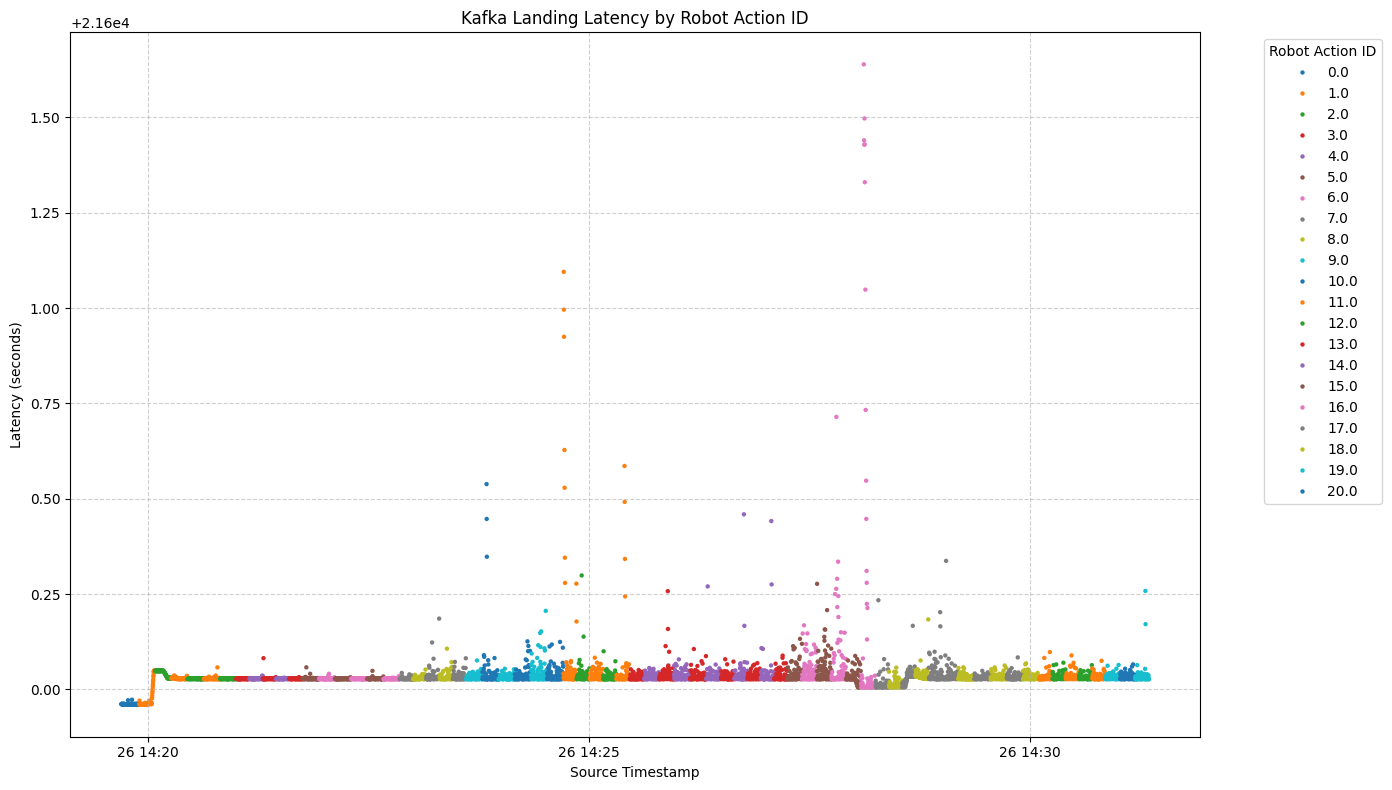

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter and sort the data subset
data_subset = df_edge_filtered.sort_values(by="source_timestamp")

plt.figure(figsize=(14, 8))
sns.scatterplot(
    data=data_subset[20:7000],
    x="source_timestamp", 
    y="source_kafka_latency", 
    hue="robot_action_id",  # Colors points by robot_action_id
    palette="tab10",        # Choose a distinct color palette
    s=10,                   # Marker size
    marker='o',
    linewidth=0
)

plt.title("Kafka Landing Latency by Robot Action ID")
plt.xlabel("Source Timestamp")
plt.ylabel("Latency (seconds)")
plt.legend(title="Robot Action ID", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

/home/ark/streaming-pipeline/notebooks/charts.py:1178: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


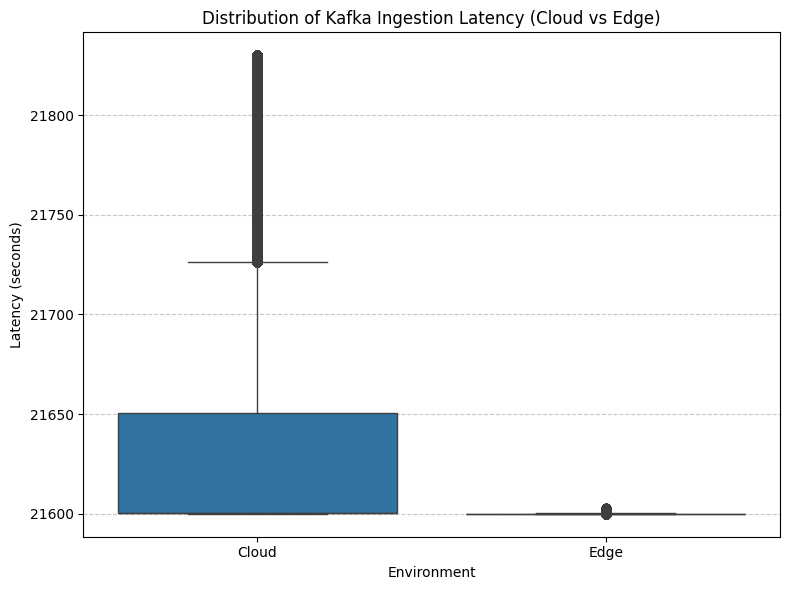

In [41]:
latency_box_plot(df_cloud_filtered, df_edge_filtered, y="source_kafka_latency")

/home/ark/streaming-pipeline/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


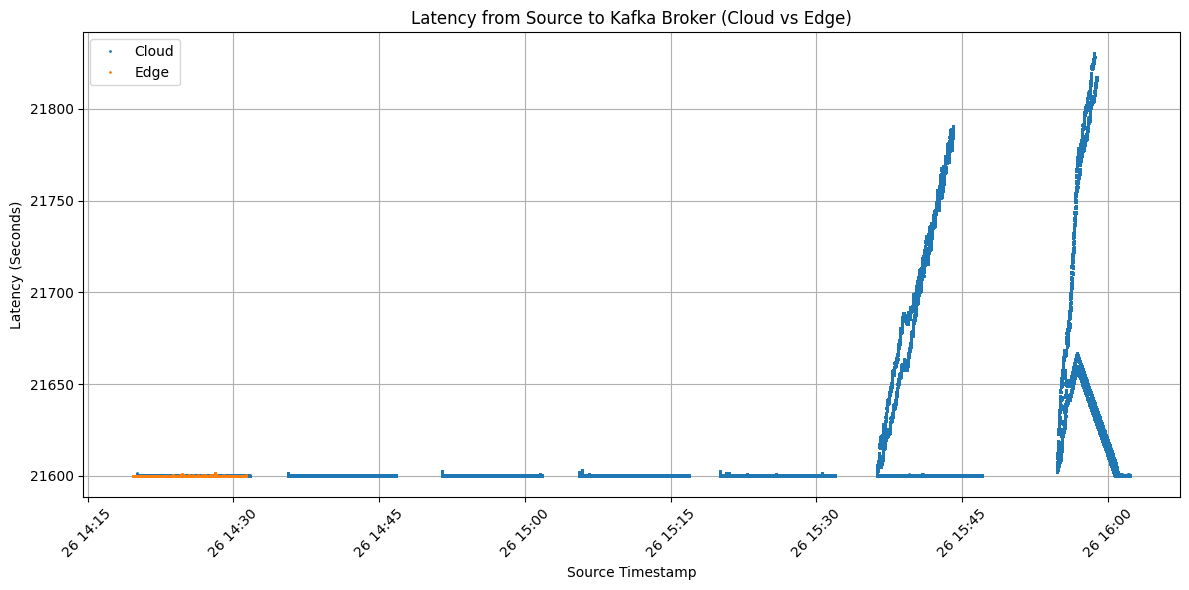

In [42]:
latency_line_plot(df_cloud_filtered, df_edge_filtered[20:7000], x="source_timestamp", y="source_kafka_latency")

📊 Statistics:
                     mean       median        std
Environment                                      
Cloud        21633.948927  21600.27055  55.843462
Edge         21600.038717  21600.04603   0.031781


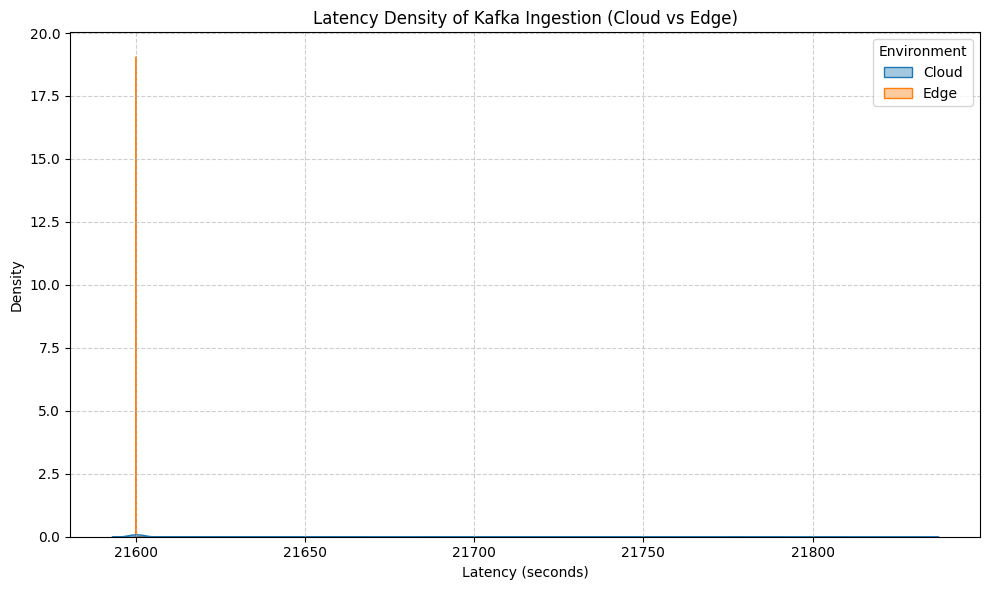

In [43]:
latency_distribution_plot(df_cloud_filtered, df_edge_filtered, x="source_kafka_latency")

/home/ark/streaming-pipeline/notebooks/charts.py:1178: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


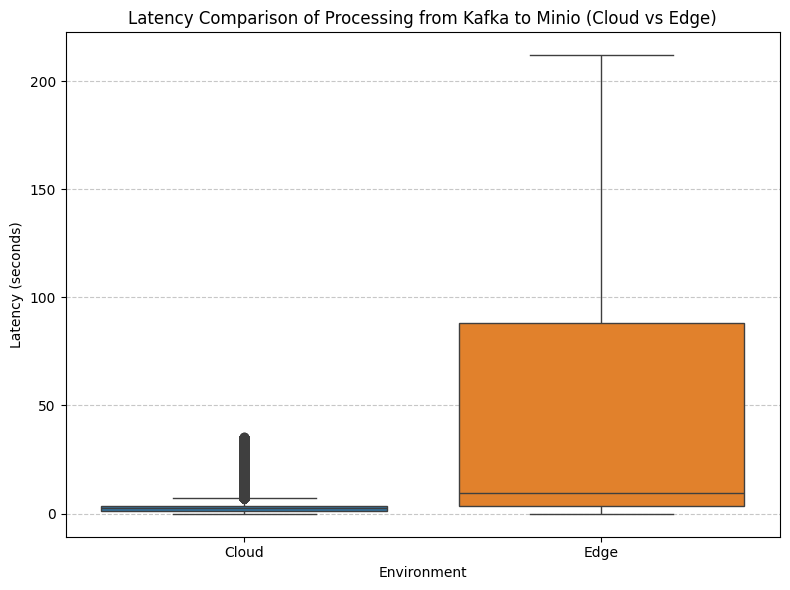

In [44]:
latency_box_plot(df_cloud_filtered, df_edge_filtered, y="kafka_landing_latency", title="Latency Comparison of Processing from Kafka to Minio (Cloud vs Edge)")

/home/ark/streaming-pipeline/notebooks/charts.py:1234: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/home/ark/streaming-pipeline/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


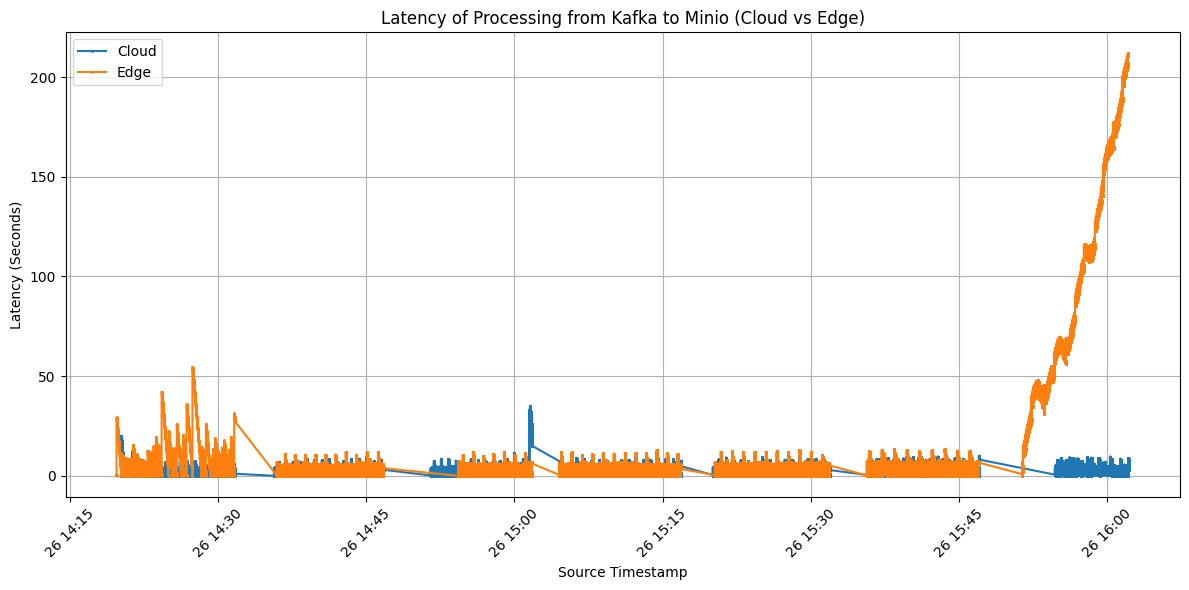

In [45]:
latency_line_plot(df_cloud_filtered, df_edge_filtered, x='source_timestamp', y='kafka_landing_latency', title='Latency of Processing from Kafka to Minio (Cloud vs Edge)', linestyle="solid")

📊 Statistics:
                  mean  median        std
Environment                              
Cloud         2.722939   2.520   2.007488
Edge         49.778090   9.632  61.593857


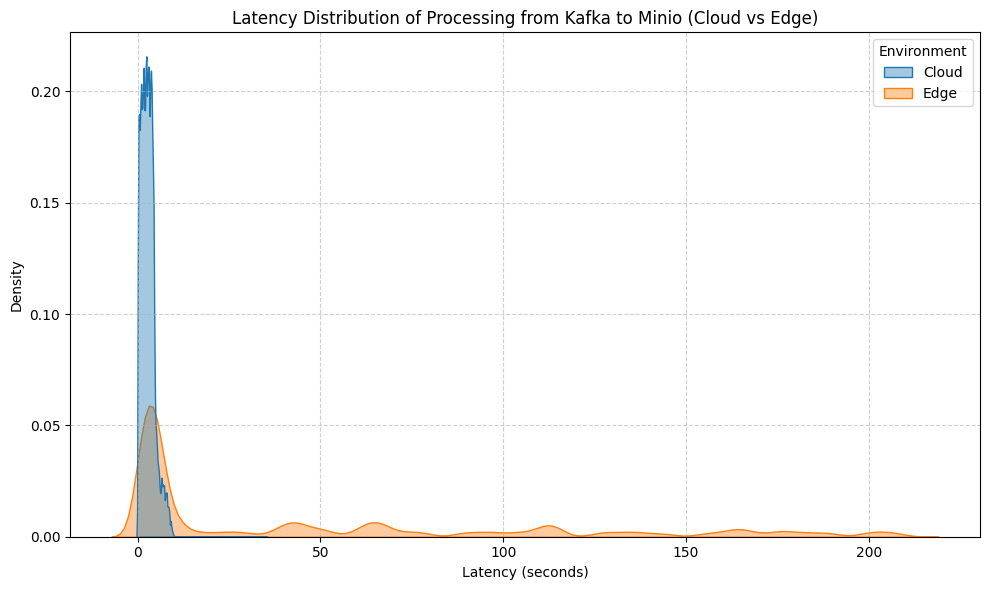

In [46]:
latency_distribution_plot(df_cloud_filtered, df_edge_filtered, x="kafka_landing_latency", title="Latency Distribution of Processing from Kafka to Minio (Cloud vs Edge)")